UNDER CONSTRUCTION

playground for joint gain control

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
im = []
for i in range(1,25):
    if i < 10:
        i = str(0) + str(i)
    im.append(plt.imread('/Users/pe/Documents/images/tid2013/reference_images/I'+str(i)+'.BMP'))

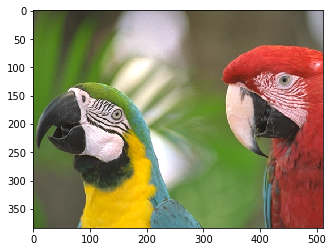

In [3]:
plt.imshow(im[22])

In [4]:
X = torch.tensor(po.rescale(np.transpose(np.stack(im), (0,3,1,2))), dtype=torch.float32)

X.shape

torch.Size([24, 3, 384, 512])

In [5]:
Xc = X - nn.functional.avg_pool2d(X, (5,5), stride=(1,1), padding=(2,2))
# Xc = Xc - torch.mean(Xc, dim=(1), keepdim=True)
C0 = torch.einsum('bchw, bdhw -> cd', [Xc,Xc]) / (24 * 384 * 512)
evals, evecs = torch.symeig(C0, eigenvectors=True)
W0 = torch.diag(torch.pow(torch.sqrt(evals), -1)) @ evecs.t()
y0 = torch.einsum('dc, bchw -> bdhw', [W0, Xc])

In [6]:
evecs, evals

(tensor([[-0.3508, -0.7362,  0.5788],
         [ 0.8024,  0.0824,  0.5911],
         [-0.4828,  0.6718,  0.5618]]),
 tensor([5.2216e-05, 1.5914e-04, 1.2168e-02]))

In [7]:
y0.min(), y0.max(), y0.shape

(tensor(-31.0789), tensor(26.4158), torch.Size([24, 3, 384, 512]))

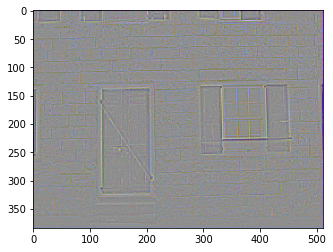

In [8]:
plt.imshow(po.rescale(np.transpose(numpy(y0), (0,2,3,1))[0]))

In [9]:
l1 = nn.Conv2d(3, 6, (5,5), bias=False, padding=(2,2))

In [10]:
a1 = nn.AvgPool2d((5,5), stride=(1,1), padding=(2,2), count_include_pad=False)

In [11]:
x1 = l1(X)

In [12]:
x1c = x1 - a1(x1)

In [13]:
x1c.shape

torch.Size([24, 6, 384, 512])

In [14]:
C = torch.einsum('bchw, bdhw -> cd', [x1c,x1c]) / (24 * 384 * 512)

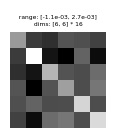

In [15]:
pt.imshow(numpy(C), zoom=16);

In [16]:
evals, evecs = torch.symeig(C, eigenvectors=True)

W = torch.diag(torch.pow(torch.sqrt(evals), -1)) @ evecs.t()

y1 = torch.einsum('dc, bchw -> bdhw', [W, x1c])

In [17]:
y1.shape

torch.Size([24, 6, 384, 512])

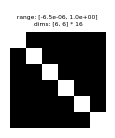

In [18]:
pt.imshow(numpy(torch.einsum('bchw, bdhw -> cd', [y1, y1])) / (24 * 384 * 512), zoom=16);

In [19]:
V = torch.randn((6, 18))
V = V / torch.norm(V, dim=0, keepdim=True)

In [20]:
np.allclose(numpy(torch.diag(V.t() @ C @ V)),
            numpy(torch.einsum('im, ij, jm -> m', [V, C, V])))

True

In [21]:
y = torch.einsum('im, bihw, bjhw, jm -> bmhw', [V, x1c, x1c, V])

In [22]:
G = V.t() @ V
O = G ** 2
Q = torch.inverse(O)

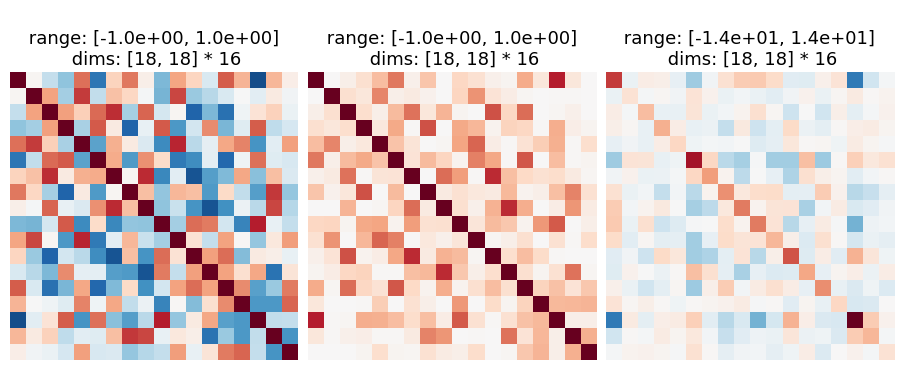

In [23]:
pt.imshow([numpy(G), numpy(O), numpy(Q)], vrange='indep0', zoom=16);

In [24]:
x1c.shape, y.shape

(torch.Size([24, 6, 384, 512]), torch.Size([24, 18, 384, 512]))